In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import END,START,MessagesState
from langgraph.graph.state import StateGraph
from langchain_core.messages import SystemMessage

from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv
load_dotenv()

True

In [17]:
from langgraph.checkpoint.memory import MemorySaver


In [18]:
os.environ['OPENAI_API_KEY']=os.getenv("API_KEY")
print(os.getenv("API_KEY"))
model_name = "nvidia/nemotron-3-nano-30b-a3b:free"
base_url = "https://openrouter.ai/api/v1"


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


In [19]:
llm=ChatOpenAI(api_key=os.getenv("API_KEY"),model_name=model_name,base_url=base_url)

In [20]:
llm.invoke("hi")

AIMessage(content='Hello! How can I assist you today? 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 17, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 21, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0, 'video_tokens': 0}, 'cost': 0, 'is_byok': False, 'cost_details': {'upstream_inference_cost': None, 'upstream_inference_prompt_cost': 0, 'upstream_inference_completions_cost': 0}}, 'model_provider': 'openai', 'model_name': 'nvidia/nemotron-3-nano-30b-a3b:free', 'system_fingerprint': None, 'id': 'gen-1767846683-MvVSlcZPGRFYxPH2t07x', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b9bdf-a280-7951-9b06-2969448c5457-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 17, 'output_tokens': 33, 'total_tokens': 50, 'input_token_details': {'

In [21]:
class AgentState(MessagesState):
    next_agent:str

In [23]:
@tool
def search_web(query:str)->str:
    """Search for the web for information"""

    search = TavilySearchResults(max_results=3)
    results = search.invoke(query)
    return str(results)

@tool
def write_summary(content:str)->str:
    """Write a summary of the content"""
    summary=f"Summary of findings:\n\n{content[:500]}...."
    
    return content

In [24]:
def researcher_agent(state:AgentState):
    "Researcher agent that searches for information"
    messages = state['messages']
    system_msg = SystemMessage(content="You are a researcher agent that searches for information")

    researcher_llm = llm.bind_tools([search_web])
    response=researcher_llm.invoke([system_msg]+messages)

    return {
        "messages":[response],
        "next_agent":"writer"
    }

In [25]:
def writer_agent(state:AgentState):
    """"Writer agent that creates summaries"""
    messages = state["messages"]
    system_rag = SystemMessage(content="You are a technical writer. Review the conversation and create a clear, concise summary summary of the findings.")
    response = llm.invoke(messages + [system_rag])
    return {"messages":messages + [response]}

In [26]:
def execute_tools(state:AgentState):
    """Execute tools"""
    messages = state["messages"]
    last_message= messages[-1]

    if hasattr(last_message,"tool_cools") and last_message.tool_calls:
        tool_node = ToolNode([search_web,write_summary])
        response = tool_node.invoke(state)
        return response


    return state


In [27]:
workflow = StateGraph(MessagesState)

workflow.add_node("researcher",researcher_agent)
workflow.add_node("writer",writer_agent)

workflow.add_edge(START,"researcher")
workflow.add_edge("researcher","writer")
workflow.add_edge("writer",END)
final_workflow = workflow.compile()
print(final_workflow)



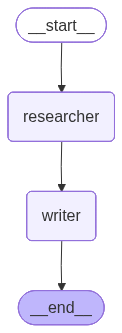

In [28]:
final_workflow

In [15]:
llm.invoke("howdy")

AIMessage(content="\n\nHowdy partner! 😄 \n\nGood to hear from you. Is there anything I can help you with today? Just let me know what's on your mind, or if you just wanted to say hi, that's perfectly fine too! \n\nDo you have any questions, want to brainstorm ideas, or just want to chat?\n\n\n\n", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 18, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0, 'video_tokens': 0}, 'cost': 0, 'is_byok': False, 'cost_details': {'upstream_inference_cost': None, 'upstream_inference_prompt_cost': 0, 'upstream_inference_completions_cost': 0}}, 'model_provider': 'openai', 'model_name': 'google/gemma-3-27b-it:free', 'system_fingerprint': None, 'id': 'gen-1767846473-3tq4eyv6SMYeOSyfIcYC', 'finis

In [29]:
responses=final_workflow.invoke({"messages":"Research about the  usecase of agentic ai in business"})

In [30]:
responses["messages"][-1].content

'**Summary: Agentic AI Use Cases in Business**\n\nAgentic AI—systems that autonomously plan, decide, and act toward defined goals—has moved from research labs into production environments. Across industries, businesses are leveraging agentic capabilities to augment or replace human workflows, drive efficiency, and unlock new revenue streams.\n\n| Domain | Key Use Cases | Business Impact |\n|--------|---------------|-----------------|\n| **Customer Experience** | • Autonomous chatbots that resolve complex queries, upsell, or negotiate returns in real‑time.<br>• Personalized recommendation agents that curate product bundles and dynamically adjust pricing. | Higher conversion rates, reduced support costs, increased NPS. |\n| **Operations & Supply Chain** | • Self‑optimizing logistics agents that reroute shipments, adjust inventory levels, and negotiate carrier contracts.<br>• Predictive maintenance agents that schedule repairs before failures occur. | Lower inventory carrying cost, 10‑30\

In [123]:
from typing import Dict,List,Any
from langchain_core.messages import AIMessage

class SupervisorState(MessagesState):
    """State for the supervisor multi-agent system"""
    current_agent: str = ""
    task_assingments: Dict[str,List[str]] = {}
    agent_outputs: Dict[str,Any] = {}
    workflow_stage: str = "initial"
    iteration_count: int = 0
    max_interations: int = 10
    final_output: str = ""
    next_agent: str = ""
    current_task: str = ""

In [124]:
def analyst_agent(state:SupervisorState):
    """Analyst uses llm to analyze the research"""
    research_data  = state.get("research_data","")
    task = state.get("task","")

    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

    Research Data: {research_data}
    
    Provide:
    1.Key insights and patterns
    2.Strategic implications
    3.Risks and opportunities
    4. Recommendations

    Focus on actionable insights related to : {task}
    """
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis= analysis_response.content

    agent_message = f"Analys: Ive completed the analysis/\n\n Top insights:\n{analysis[:400]}..."
    
    return {"messages":[HumanMessage(content=agent_message)],
    "analysis":analysis,
    "next_agent":"supervisor"}
    

In [125]:
def create_supervisor_chain():
    from langchain_core.prompts import ChatPromptTemplate
    """Creates the supervisor decision chain"""
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor for a team of agents:
        1. Researcher - Gathers information and data
        2. Analyst - Analyzes the data and provides insights
        3. Writer - Creates reports and suuumaries
        
        Based on the current state and conversation, decide which agent should work next.
        If the task is complete , respond with "DONE".

        Current State:
        - Hes research data: {has_research}
        - Hes analysis: {has_analysis}
        - Has report: {has_report}

        Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
        """),
        ("human", "{task}")
    ])
    return supervisor_prompt | llm


In [49]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """ Supervisor decides next agent using Llms """
    messages = state['messages']
    task  = messages[-1].content if messages else "No task"

    has_research  = bool(state.get("research_data"))
    has_analysis = bool(state.get("analysis_data"))
    has_report = bool(state.get("final_report",""))

    chain  = create_supervisor_chain()
    decision = chain.invoke({
        "task":task,
        "has_research":has_research,
        "has_analysis":has_analysis,
        "has_report":has_report
    })

    decision_text  = decision.content.strip().lower()
    print(decision_text)

    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "Supervisor: All tasks complete! Greate work team."
    elif "researccher" in decision_Text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "Supervisor: Time for researcher to gather data."
    elif "analyst" in decision_text or has_research and not has_analysis:
        next_agent = "analyst"
        supervisor_msg = "Supervisor: Time for analyst to analyze data."
    elif "writer" in decision_text or has_analysis and not has_report:
        next_agent = "writer"
        supervisor_msg = "Supervisor: Time for writer to write final report."
    else:
        next_agent = "end"
        supervisor_msg = "Supervisor: Taks seems complete."

    return {
        "messages":[AIMessage(content=supervisor_msg)],
        "next_agent":next_agent,
        "current_task":task
    }

In [126]:
from typing import Dict
from langchain_core.messages import AIMessage

def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using LLM"""

    messages = state["messages"]
    task = messages[-1].content if messages else "No task"

    # ✅ Correct boolean checks
    has_research = bool(state.get("research_data"))
    has_analysis = bool(state.get("analysis_data"))
    has_report   = bool(state.get("final_report"))

    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })

    decision_text = decision.content.strip().lower()
    print("Supervisor decision:", decision_text)

    # ✅ Routing logic
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "Supervisor: All tasks complete! Great work team."

    elif ("researcher" in decision_text) or not has_research:
        next_agent = "researcher"
        supervisor_msg = "Supervisor: Time for researcher to gather data."

    elif ("analyst" in decision_text) or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "Supervisor: Time for analyst to analyze data."

    elif ("writer" in decision_text) or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "Supervisor: Time for writer to write final report."

    else:
        next_agent = "end"
        supervisor_msg = "Supervisor: Tasks seem complete."

    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }


In [76]:
from typing import Dict
from langchain_core.messages import AIMessage

def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using LLMs."""

    messages = state["messages"]
    task = messages[-1].content if messages else "No task"

    # ✅ Correct boolean checks
    has_research = bool(state.get("research_data"))
    has_analysis = bool(state.get("analysis_data"))
    has_report   = bool(state.get("final_report"))

    # Call LLM chain
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })

    decision_text = decision.content.strip().lower()
    print("Supervisor decision:", decision_text)

    # ✅ Routing logic
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "Supervisor: All tasks complete! Great work team."

    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "Supervisor: Time for researcher to gather data."

    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "Supervisor: Time for analyst to analyze data."

    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "Supervisor: Time for writer to write final report."

    else:
        next_agent = "end"
        supervisor_msg = "Supervisor: Tasks seem complete."

    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }


In [127]:
def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher agent uses llm to gather data"""
    task = state.get("current_task","research_topic")

    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}
    
    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough"""

    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content
    agent_message = f"Researcher : Ive completed the research on '{task} .\n\n Key findings:\n{research_data}"
    return {
        "messages":[AIMessage(content=agent_message)],
        "research_data":research_data,
        "next_agent":"supervisor"
    }

In [128]:
def router(state: SupervisorState) :
    # -> Literal["supervisor","researcher","analyst","writer","__end__"]:
    """Routers to next agent based on state"""
    next_agent = state.get("next_agent","supervisor")
    if next_agent == "end" or state.get("task_complete",False):
        return END
    if next_agent in ["supervisor","researcher","analyst","writer"]:
        return next_agent

    return "supervisor"

In [129]:
def  writer_agent(state: SupervisorState) -> Dict:
    """Writer uses llm to create final report"""
    research_data = state.get("research_data","")
    analysis = state.get("analysis","")

    writing_prompt = f""" As a professional writer, create an excecutive report based on:
    Task: {task}
    Research Findings:
     {research_data[:1000]}

     Create a well-structured report with:
     1. Executive Summary
     2. Key Findings
     3. Recommendations
     4. Appendices

     Ensure the report is clear, concise, and professional.
     """

    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report=report_response.content
    final_report = f"""
    FINAL REPORT
    {'='*50}
    Generated:{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
    Task: {task}
    Research Data: {research_data}
    Analysis: {analysis}
    Report: {report}
    """
    return {"final_report": final_report}

In [130]:
workflow = StateGraph(SupervisorState)

workflow.add_node("supervisor",supervisor_agent)
workflow.add_node("researcher",researcher_agent)
workflow.add_node("analyst",analyst_agent)
workflow.add_node("writer",writer_agent)

workflow.set_entry_point("supervisor")

for node in ["supervisor","researcher","analyst","writer"]:
    workflow.add_conditional_edges(
        node,
        router,{
            "supervisor":"supervisor",
            "researcher":"researcher",
            "analyst":"analyst",
            "writer":"writer",
            END:END
        }
    )


graph=workflow.compile()



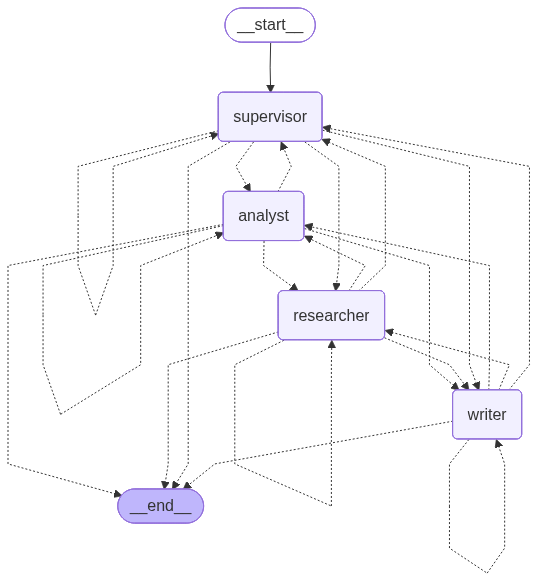

In [131]:
graph

In [137]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert AI supervisor."),
    ("human", "Task: {task}")
])

In [74]:
chain=prompt | graph

In [74]:
from langchain_core.messages import HumanMessage


In [ ]:
# graph.invoke(HumanMessage(content="What are the benefits and risks of AI in healthcare?"))

Supervisor decision: done


{'messages': [AIMessage(content='Supervisor: All tasks complete! Great work team.', additional_kwargs={}, response_metadata={}, id='caf0e689-1979-4ee8-8a83-51a4aeb93c93', tool_calls=[], invalid_tool_calls=[])],
 'next_agent': 'end',
 'current_task': 'No task'}

In [132]:
response = graph.invoke({
    "messages": [HumanMessage(content="What are the benefits and risks of AI in healthcare?")]
})


Supervisor decision: researcher
Supervisor decision: analyst
Supervisor decision: researcher
Supervisor decision: analyst
Supervisor decision: researcher
Supervisor decision: researcher
Supervisor decision: researcher
Supervisor decision: writer
Supervisor decision: researcher
Supervisor decision: researcher
Supervisor decision: researcher
Supervisor decision: researcher
Supervisor decision: researcher


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/GRAPH_RECURSION_LIMIT

In [133]:
response

{'messages': [HumanMessage(content='What are the benefits and risks of AI in healthcare?', additional_kwargs={}, response_metadata={}, id='1de8ff1a-bf6c-42a3-84c6-569b0e338d67'),
  AIMessage(content="📋 Supervisor: Let's start with research. Assigning to Researcher...", additional_kwargs={}, response_metadata={}, id='6f6b8edd-866f-481c-a212-63a8d0f60452', tool_calls=[], invalid_tool_calls=[]),
  AIMessage(content="🔍 Researcher: I've completed the research on 'What are the benefits and risks of AI in healthcare?'.\n\nKey findings:\n**AI in Healthcare – Benefits, Risks, and Evidence (2023‑2025)**  \n\n---\n\n## 1. Key Facts & Background  \n\n| Aspect | Details |\n|--------|---------|\n| **Definition** | Application of machine‑learning (ML), deep‑learning (DL), natural‑language processing (NLP), and other AI techniques to analyze health data, support clinical decision‑making, automate workflows, or develop new therapeutics. |\n| **Market Size** | Global AI‑in‑healthcare market ≈ **US$\u202

In [ ]:
llm.invoke("are you able to make an image")


AIMessage(content='I can’t generate images directly, but I can definitely help you **plan, describe, and create** them! Here’s how we can work together:\n\n### 1. Brainstorm the Concept\n- **What’s the theme or subject?** (e.g., a futuristic city skyline, a cozy reading nook, a fantasy creature, a logo, etc.)\n- **What mood or style are you after?** (e.g., minimalist, hyper‑realistic, watercolor, neon cyberpunk, vintage illustration)\n- **Any specific details?** (colors, characters, objects, perspective, lighting)\n\n### 2. Choose the Right Tool\n| Tool | Best For | Quick Prompt Tips |\n|------|----------|-------------------|\n| **DALL‑E / DALL‑E\u202f3** | Clean, detailed illustrations & realistic photos | Include explicit style words (“digital painting”, “photorealistic”) and describe composition (“wide‑angle view from above”) |\n| **Midjourney** | Artistic, painterly, and stylized results | Use “--v 5” for version, add “--ar 16:9” for aspect ratio, mention artists or medium (“in the

In [85]:
class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""

In [108]:

from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime

In [109]:
class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""

In [110]:
from langchain_core.prompts import ChatPromptTemplate
def create_supervisor_chain():
    """Creates the supervisor decision chain"""
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights  
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
"""),
        ("human", "{task}")
    ])
    
    return supervisor_prompt | llm

In [111]:
llm=ChatOpenAI(api_key=os.getenv("API_KEY"),model_name=model_name,base_url=base_url)

In [116]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using Groq LLM"""
    
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    
    # Check what's been completed
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))
    
    # Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })
    
    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)
    
    # Determine next agent
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."
    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "📋 Supervisor: Let's start with research. Assigning to Researcher..."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "📋 Supervisor: Research done. Time for analysis. Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "📋 Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."
    else:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: Task seems complete."
    
    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [112]:
def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher uses Groq to gather information"""
    
    task = state.get("current_task", "research topic")
    
    # Create research prompt
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""
    
    # Get research from LLM
    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content
    
    # Create agent message
    agent_message = f"🔍 Researcher: I've completed the research on '{task}'.\n\nKey findings:\n{research_data[:500]}..."
    print(agent_message)
    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent": "supervisor"
    }


In [113]:
# ===================================
# Agent 2: Analyst (using Groq)
# ===================================

def analyst_agent(state: SupervisorState) -> Dict:
    """Analyst uses Groq to analyze the research"""
    
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")
    
    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

Research Data:
{research_data}

Provide:
1. Key insights and patterns
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""
    
    # Get analysis from LLM
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content
    
    # Create agent message
    agent_message = f"📊 Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."
    print(agent_message)
    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }

In [114]:
def writer_agent(state: SupervisorState) -> Dict:
    """Writer uses Groq to create final report"""
    
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""
    
    # Get report from LLM
    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = report_response.content
    
    # Create final formatted report
    final_report = f"""
📄 FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""
    print(final_report)
    return {
        "messages": [AIMessage(content=f"✍️ Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [115]:
# Router Function
# ===================================

def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""
    
    next_agent = state.get("next_agent", "supervisor")
    
    if next_agent == "end" or state.get("task_complete", False):
        return END
        
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
        
    return "supervisor"

In [117]:
# Create workflow
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

# Add routing
for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )

graph=workflow.compile()

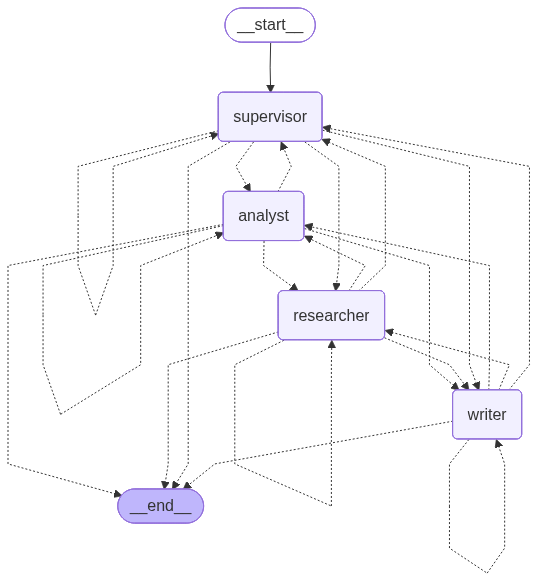

In [118]:

graph

In [119]:

response=graph.invoke(HumanMessage(content="What are the benefits and risks of AI in healthcare?"))

done


In [120]:

response

{'messages': [AIMessage(content='✅ Supervisor: All tasks complete! Great work team.', additional_kwargs={}, response_metadata={}, id='fa32b31b-fc5d-488c-8c55-b5558a7b4343', tool_calls=[], invalid_tool_calls=[])],
 'next_agent': 'end',
 'current_task': 'No task'}

In [121]:
response = graph.invoke({
    "messages": [HumanMessage(content="What are the benefits and risks of AI in healthcare?")]
})


researcher
🔍 Researcher: I've completed the research on 'What are the benefits and risks of AI in healthcare?'.

Key findings:
**AI in Healthcare – Benefits, Risks, and Evidence (2023‑2025)**  

---

## 1. Key Facts & Background  

| Aspect | Details |
|--------|---------|
| **Definition** | Application of machine‑learning (ML), deep‑learning (DL), natural‑language processing (NLP), and other AI techniques to analyze health data, support clinical decision‑making, automate workflows, or develop new therapeutics. |
| **Market Size** | Global AI‑in‑healthcare market ≈ **US$ 55 bn (2023)**, projected to reach **US$ 188 bn b...
analyst
📊 Analyst: I've completed the analysis.

Top insights:
## Executive Summary  

| What you asked for | What you get |
|--------------------|--------------|
| **Key insights & patterns** | A concise map of the most robust trends emerging from 2023‑2025 AI‑in‑healthcare data. |
| **Strategic implications** | How those trends reshape the value‑chain for researche

In [122]:
response

{'messages': [HumanMessage(content='What are the benefits and risks of AI in healthcare?', additional_kwargs={}, response_metadata={}, id='1de8ff1a-bf6c-42a3-84c6-569b0e338d67'),
  AIMessage(content="📋 Supervisor: Let's start with research. Assigning to Researcher...", additional_kwargs={}, response_metadata={}, id='6f6b8edd-866f-481c-a212-63a8d0f60452', tool_calls=[], invalid_tool_calls=[]),
  AIMessage(content="🔍 Researcher: I've completed the research on 'What are the benefits and risks of AI in healthcare?'.\n\nKey findings:\n**AI in Healthcare – Benefits, Risks, and Evidence (2023‑2025)**  \n\n---\n\n## 1. Key Facts & Background  \n\n| Aspect | Details |\n|--------|---------|\n| **Definition** | Application of machine‑learning (ML), deep‑learning (DL), natural‑language processing (NLP), and other AI techniques to analyze health data, support clinical decision‑making, automate workflows, or develop new therapeutics. |\n| **Market Size** | Global AI‑in‑healthcare market ≈ **US$\u202

In [156]:

from ollama import OllamaClient
import os
os.environ["OLLAMA_API_KEY"]="cac58fb99f18420eb4a7b2afcb409b9d.MQ5heXzmp5jsTC5Ubcw2Nx5H"

ollama_client = ollama_client(model="mistral")
response = ollama_client.chat("What are the benefits and risks of AI in healthcare?")
print(response)




ImportError: cannot import name 'OllamaClient' from 'ollama' (c:\Users\Rayan Ahmed.R\Downloads\LANGSMITH\venv\Lib\site-packages\ollama\__init__.py)

In [159]:
from ollama import Ollama
import os

os.environ["OLLAMA_API_KEY"] = "your_api_key_here"

# Create client instance
ollama_client = OllamaClient()


ImportError: cannot import name 'Ollama' from 'ollama' (c:\Users\Rayan Ahmed.R\Downloads\LANGSMITH\venv\Lib\site-packages\ollama\__init__.py)

AttributeError: 'generator' object has no attribute 'invoke'

In [ ]:
stream

<generator object Client._request.<locals>.inner at 0x00000154E274FA70>

In [149]:
pip install ollama

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [73]:
from langchain_core.messages import HumanMessage

graph.invoke({
    "messages": [
        HumanMessage(content="What are the benefits and risks of AI in healthcare?")
    ]
})


KeyError: "Input to ChatPromptTemplate is missing variables {'hes_analysis', 'taks'}.  Expected: ['has_report', 'has_research', 'hes_analysis', 'taks'] Received: ['task', 'has_research', 'has_analysis', 'has_report']\nNote: if you intended {hes_analysis} to be part of the string and not a variable, please escape it with double curly braces like: '{{hes_analysis}}'.\nFor troubleshooting, visit: https://docs.langchain.com/oss/python/langchain/errors/INVALID_PROMPT_INPUT "

In [60]:
from langchain_core.messages import HumanMessage


In [35]:
from typing import Dict, List, Any


In [ ]:
# from IPython.display import Image, display
# display(Image("multiagent.png").draw_mermaid_png())

AttributeError: 'Image' object has no attribute 'draw_mermaid_png'

In [6]:
pip install langchain

   ---------------------------------------- 0.0/105.0 kB ? eta -:--:--
   ----------- --------------------------- 30.7/105.0 kB 640.0 kB/s eta 0:00:01
   -------------------------------------- - 102.4/105.0 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 105.0/105.0 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
